In [1]:
# Optimization for Machine Learning
# Problem: projected gradient descent for SVM

%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pegasos import *
from cyclic_coordinate_descent import *
from random_coordinate_descent import *
from utils import *


from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler
import os, struct
from array import array
from SMO import SMO
from RSMO import RSMO
from SMO1 import SMO1
from RSMO1 import RSMO1

np.random.seed(1337)

kwargs = {'linewidth' : 3.5}
font = {'weight' : 'normal', 'size'   : 24}
matplotlib.rc('font', **font)


### Load mnist training and validation images. Plot examples from both sets and show their corresponding labels as verification.

In [2]:
# mnist load images
train_imgs_dir = './dataset/mnist/train-images.idx3-ubyte'
train_labels_dir = './dataset/mnist/train-labels.idx1-ubyte'
val_imgs_dir = './dataset/mnist/t10k-images.idx3-ubyte'
val_labels_dir = './dataset/mnist/t10k-labels.idx1-ubyte'
train_imgs, train_labels = mnist_data_loader(train_imgs_dir, train_labels_dir)
print("mnist: number of training examples", train_imgs.shape[0])

val_imgs, val_labels = mnist_data_loader(val_imgs_dir, val_labels_dir)
print("mnist: number of validation examples", val_imgs.shape[0])
HEIGHT = 28
WIDTH = 28

# Reshape images to vectors
train_vectors_10000 = train_imgs.reshape(-1, HEIGHT * WIDTH)[:10000, :]
train_labels_10000 = train_labels[:10000]

train_vectors_5000 = train_imgs.reshape(-1, HEIGHT * WIDTH)[:5000, :]
train_labels_5000 = train_labels[:5000]

train_vectors_3000 = train_imgs.reshape(-1, HEIGHT * WIDTH)[:3000, :]
train_labels_3000 = train_labels[:3000]

train_vectors_1000 = train_imgs.reshape(-1, HEIGHT * WIDTH)[:1000, :]
train_labels_1000 = train_labels[:1000]

train_vectors_300 = train_imgs.reshape(-1, HEIGHT * WIDTH)[:300, :]
train_labels_300 = train_labels[:300]

val_vectors = val_imgs.reshape(-1, HEIGHT * WIDTH)

mnist: number of training examples 11769
mnist: number of validation examples 1932


## Plot Functions

In [3]:
# initialize w, lambda
# num_examples, num_features = train_vectors.shape
_, num_features = train_vectors_10000.shape

def error_plot(w, _lambda, img_vectors, labels, algorithm, dilate=1, yscale='log'):
    """plot errors"""
    error_list = cal_objective_dilate(w, _lambda, img_vectors, labels, dilate)
    print(algorithm+" error:", error_list[-1])
    plt.xlabel('Step')
    plt.ylabel('Error')
#     plt.yscale(yscale)
    num_iters = len(error_list)
    plt.plot(np.linspace(0, num_iters*dilate, num=num_iters), error_list, **kwargs)

def cal_objective_dilate(w, _lambda, img_vectors, labels, dilate=1):
    num_iters = len(w)
    return [objective(x, _lambda, img_vectors, labels) \
                                for x in w[0:num_iters:dilate]]

def acc_plot(w, img_vectors, labels, algorithm, dilate=1):
    """plot accuracies"""
    acc_list = cal_acc_dilate(w, img_vectors, labels, dilate)
    print(algorithm+" acc:", acc_list[-1])
    plt.xlabel('Step')
    plt.ylabel('Acc')
    num_iters = len(acc_list)
    plt.plot(np.linspace(0, num_iters*dilate, num=num_iters), acc_list, **kwargs)

def cal_acc_dilate(w, img_vectors, labels, dilate=1):
    num_iters = len(w)
    return [compute_accuracy(x, img_vectors, labels) for x in w[0:num_iters:dilate]]

## Training error

In [4]:
def average_weight(w):
    w_sum = np.zeros([num_features,1])
    w_average = []
    for i in range(0,len(w)):
        w_sum += w[i]
        w_average.append(w_sum/(i+1))
    return w_average

def set_pegasos_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = 3000
    return _lambda, num_steps, w0

def set_primal_cyclic_cd_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = 4
    t_bias = 10
    return _lambda, num_steps, w0, t_bias

def set_primal_random_cd_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = 4
    t_bias = 10
    return _lambda, num_steps, w0, t_bias


In [ ]:
# 10000
# pegasos
pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
                        w0, [pegasos_lambda]*pegasos_num_steps, train_vectors_10000, train_labels_10000, proj)   # training
pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors_10000, train_labels_10000)) # print final training error
print("        ")

# primal cyclic coordinate descent
primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
                        w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors_10000, train_labels_10000, t_bias, proj)
primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors_10000, train_labels_10000))
print("        ")

# primal random coordinate descent
primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
                        w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors_10000, train_labels_10000, t_bias, proj)
primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors_10000, train_labels_10000))
print("        ")

# SVM using SMO descend
smo_model = SMO(C=1.0)
smo_model.fit(train_vectors_10000, train_labels_10000)
print("        ")

# Random SMO
rsmo_model = RSMO(C=1.0)
rsmo_model.fit(train_vectors_10000, train_labels_10000)

Pegasos training starts...
Iterations: 2999    total_time: 0.622434139251709
Pegasos training ends...
Pegasos training error   0.09675436844890932
        
CCD training starts...
epoch: 0    total_time: 45.97997713088989
epoch: 1    total_time: 82.18884015083313
epoch: 2    total_time: 117.46349811553955
epoch: 3    total_time: 152.1953089237213
CCD training ends...
CCD training error:   0.12084888281195652
        
RCD training starts...


In [ ]:
print("Pegasos total running time:", pegasos_running_time[-1], "     Pegasos total number of iterations:", 3000)
print("CCD total running time:", primal_cyclic_cd_running_time[-1], "      CCD total number of iterations:",4*784)
print("RCD total running time:", primal_random_cd_running_time[-1], "     RCD total number of iterations:",4*784)
print("SMO total running time:", smo_model.time_ls[3000], "     SMO total number of iterations: ", 11769)
print("RSMO total running time:", rsmo_model.time_ls[3000], "     RSMO total number of iterations:",11769)

In [ ]:
# training error plot
plot_dilation = 20
plt.figure(figsize=(8, 8))
plot_iters = 3000

error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, train_vectors_10000, train_labels_10000, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, train_vectors_10000, train_labels_10000, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, train_vectors_10000, train_labels_10000, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, train_vectors_10000, train_labels_10000, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, train_vectors_10000, train_labels_10000, 'rSMO', plot_dilation)

plt.title(' Training Error with 10000')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [ ]:
# training acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], train_vectors_10000, train_labels_10000, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], train_vectors_10000, train_labels_10000, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], train_vectors_10000, train_labels_10000, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], train_vectors_10000, train_labels_10000, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], train_vectors_10000, train_labels_10000, 'rSMO', plot_dilation)

plt.title(' Training Acc with 10000')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [ ]:
# test error plot
plt.figure(figsize=(8, 8))
error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, val_vectors, val_labels, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, val_vectors, val_labels, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, val_vectors, val_labels, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'rSMO', plot_dilation)
plt.title(' Testing Error with 10000')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [ ]:
# test acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], val_vectors, val_labels, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], val_vectors, val_labels, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], val_vectors, val_labels, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], val_vectors, val_labels, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], val_vectors, val_labels, 'rSMO', plot_dilation)

plt.title(' Testing Acc with 10000')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [5]:
# 5000
# pegasos
pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
                        w0, [pegasos_lambda]*pegasos_num_steps, train_vectors_5000, train_labels_5000, proj)   # training
pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors_5000, train_labels_5000)) # print final training error
print("        ")

# primal cyclic coordinate descent
primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
                        w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors_5000, train_labels_5000, t_bias, proj)
primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors_5000, train_labels_5000))
print("        ")

# primal random coordinate descent
primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
                        w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors_5000, train_labels_5000, t_bias, proj)
primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors_5000, train_labels_5000))
print("        ")

# SVM using SMO descend
smo_model = SMO(C=1.0)
smo_model.fit(train_vectors_5000, train_labels_5000)
print("        ")

# Random SMO
rsmo_model = RSMO(C=1.0)
rsmo_model.fit(train_vectors_5000, train_labels_5000)

Pegasos training starts...
Iterations: 2999    total_time: 0.4073936939239502
Pegasos training ends...
Pegasos training error   0.09539675556816485
        
CCD training starts...
epoch: 0    total_time: 22.918172121047974
epoch: 1    total_time: 40.90295195579529
epoch: 2    total_time: 58.27444314956665
epoch: 3    total_time: 75.47781682014465
CCD training ends...
CCD training error:   0.11879300895544255
        
RCD training starts...
epoch: 0    total_time: 26.4359769821167
epoch: 1    total_time: 45.68193793296814
epoch: 2    total_time: 63.284634828567505
epoch: 3    total_time: 79.71686816215515
RCD training ends...
RCD training error:   0.1165964473243804
        
SMO training start
SMO training ends....
        
RSMO training start
RSMO training ends....


In [6]:
print("Pegasos total running time:", pegasos_running_time[-1], "     Pegasos total number of iterations:", 3000)
print("CCD total running time:", primal_cyclic_cd_running_time[-1], "      CCD total number of iterations:",4*784)
print("RCD total running time:", primal_random_cd_running_time[-1], "     RCD total number of iterations:",4*784)
print("SMO total running time:", smo_model.time_ls[3000], "     SMO total number of iterations: ", 11769)
print("RSMO total running time:", rsmo_model.time_ls[3000], "     RSMO total number of iterations:",11769)

Pegasos total running time: 0.4073929786682129      Pegasos total number of iterations: 3000
CCD total running time: 75.4778151512146       CCD total number of iterations: 3136
RCD total running time: 79.71686697006226      RCD total number of iterations: 3136
SMO total running time: 34.015289068222046      SMO total number of iterations:  11769
RSMO total running time: 34.32960605621338      RSMO total number of iterations: 11769


Pegasos error: 0.09541763346437473
CCD error: 0.12104469594880796
RCD error: 0.11787952571484289
SMO error: 0.11343065568372523
rSMO error: 0.12907084241527567


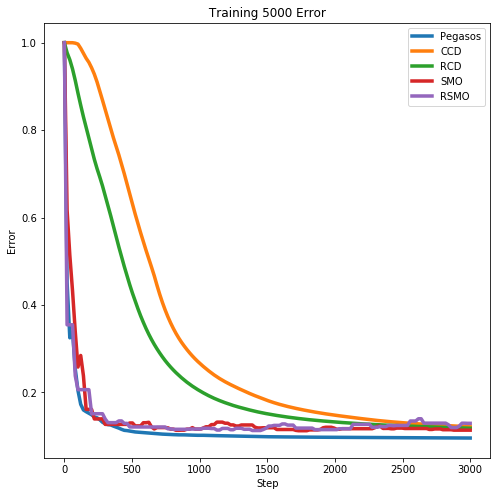

In [7]:
# training 5000 error plot
plot_dilation = 20
plt.figure(figsize=(8, 8))
plot_iters = 3000

error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, train_vectors_5000, train_labels_5000, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, train_vectors_5000, train_labels_5000, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, train_vectors_5000, train_labels_5000, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, train_vectors_5000, train_labels_5000, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, train_vectors_5000, train_labels_5000, 'rSMO', plot_dilation)

plt.title(' Training 5000 Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos acc: 0.9834
CCD acc: 0.9752
RCD acc: 0.9808
SMO acc: 0.981
rSMO acc: 0.9764


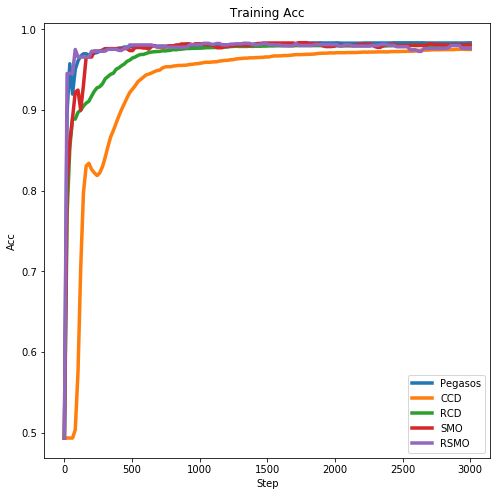

In [8]:
# training acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], train_vectors_5000, train_labels_5000, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], train_vectors_5000, train_labels_5000, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], train_vectors_5000, train_labels_5000, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], train_vectors_5000, train_labels_5000, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], train_vectors_5000, train_labels_5000, 'rSMO', plot_dilation)

plt.title(' Training Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos error: 0.10019273001241552
CCD error: 0.12622644797046356
RCD error: 0.12037134491396581
SMO error: 0.118553856290575
rSMO error: 0.1249380854335001


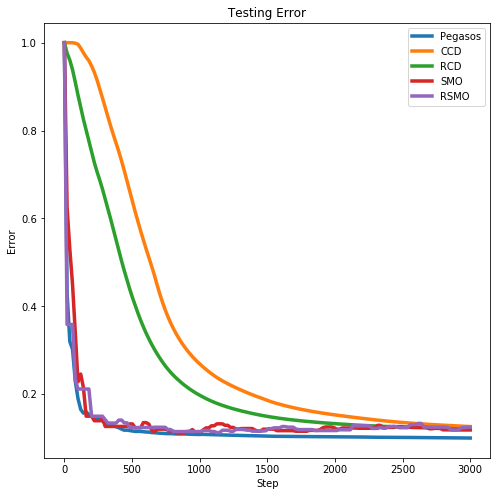

In [9]:
# test error plot
plt.figure(figsize=(8, 8))
error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, val_vectors, val_labels, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, val_vectors, val_labels, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, val_vectors, val_labels, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'rSMO', plot_dilation)
plt.title(' Testing Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos acc: 0.984472049689441
CCD acc: 0.972567287784679
RCD acc: 0.9824016563146998
SMO acc: 0.9787784679089027
rSMO acc: 0.9761904761904762


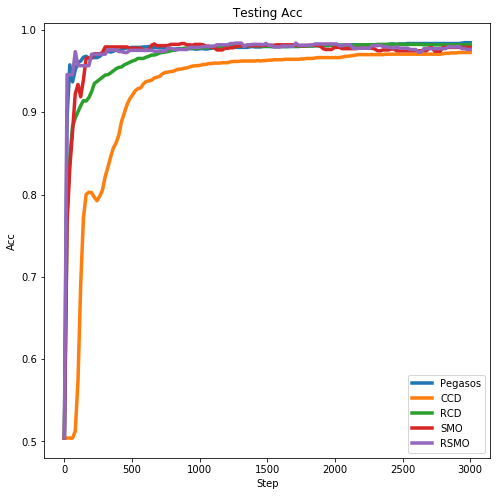

In [10]:
# test acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], val_vectors, val_labels, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], val_vectors, val_labels, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], val_vectors, val_labels, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], val_vectors, val_labels, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], val_vectors, val_labels, 'rSMO', plot_dilation)

plt.title(' Testing Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [11]:
# # 3000
# # pegasos
# pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
# pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
#                         w0, [pegasos_lambda]*pegasos_num_steps, train_vectors_3000, train_labels_3000, proj)   # training
# pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
# print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors_3000, train_labels_3000)) # print final training error
# print("        ")

# # primal cyclic coordinate descent
# primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
# primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
#                         w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors_3000, train_labels_3000, t_bias, proj)
# primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
# print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors_3000, train_labels_3000))
# print("        ")

# # primal random coordinate descent
# primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
# primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
#                         w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors_3000, train_labels_3000, t_bias, proj)
# primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
# print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors_3000, train_labels_3000))
# print("        ")

# # SVM using SMO descend
# smo_model = SMO(C=1.0)
# smo_model.fit(train_vectors_3000, train_labels_3000)
# print("        ")

# # Random SMO
# rsmo_model = RSMO(C=1.0)
# rsmo_model.fit(train_vectors_3000, train_labels_3000)

In [12]:
# # training 3000 error plot
# plot_dilation = 20
# plt.figure(figsize=(8, 8))
# plot_iters = 3000

# error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, train_vectors_3000, train_labels_3000, 'Pegasos', plot_dilation)
# error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, train_vectors_3000, train_labels_3000, 'CCD', plot_dilation)
# error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, train_vectors_3000, train_labels_3000, 'RCD', plot_dilation)
# error_plot(smo_model.w_ls[:plot_iters], 1.0, train_vectors_3000, train_labels_3000, 'SMO', plot_dilation)
# error_plot(rsmo_model.w_ls[:plot_iters], 1.0, train_vectors_3000, train_labels_3000, 'rSMO', plot_dilation)

# plt.title(' Training 3000 Error ')
# plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [13]:
# 1000
# pegasos
pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
                        w0, [pegasos_lambda]*pegasos_num_steps, train_vectors_1000, train_labels_1000, proj)   # training
pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors_1000, train_labels_1000)) # print final training error
print("        ")

# primal cyclic coordinate descent
primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
                        w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors_1000, train_labels_1000, t_bias, proj)
primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors_1000, train_labels_1000))
print("        ")

# primal random coordinate descent
primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
                        w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors_1000, train_labels_1000, t_bias, proj)
primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors_1000, train_labels_1000))
print("        ")

# SVM using SMO descend
smo_model = SMO1(C=1.0)
smo_model.fit(train_vectors_1000, train_labels_1000)
print("        ")

# Random SMO
rsmo_model = RSMO1(C=1.0)
rsmo_model.fit(train_vectors_1000, train_labels_1000)

Pegasos training starts...
Iterations: 2999    total_time: 0.1992478370666504
Pegasos training ends...
Pegasos training error   0.08378696940849252
        
CCD training starts...
epoch: 0    total_time: 4.496784925460815
epoch: 1    total_time: 7.899645805358887
epoch: 2    total_time: 11.187149047851562
epoch: 3    total_time: 14.441979885101318
CCD training ends...
CCD training error:   0.10188699836926143
        
RCD training starts...
epoch: 0    total_time: 4.632170915603638
epoch: 1    total_time: 8.135965824127197
epoch: 2    total_time: 11.556195974349976
epoch: 3    total_time: 14.946369886398315
RCD training ends...
RCD training error:   0.10309395419071588
        
SMO training start
SMO training ends....
        
RSMO training start
RSMO training ends....


In [14]:
print("Pegasos total running time:", pegasos_running_time[-1], "     Pegasos total number of iterations:", 3000)
print("CCD total running time:", primal_cyclic_cd_running_time[-1], "      CCD total number of iterations:",4*784)
print("RCD total running time:", primal_random_cd_running_time[-1], "     RCD total number of iterations:",4*784)
print("SMO total running time:", smo_model.time_ls[3000], "     SMO total number of iterations: ", 11769)
print("RSMO total running time:", rsmo_model.time_ls[3000], "     RSMO total number of iterations:",11769)

Pegasos total running time: 0.19924688339233398      Pegasos total number of iterations: 3000
CCD total running time: 14.441977977752686       CCD total number of iterations: 3136
RCD total running time: 14.946368932723999      RCD total number of iterations: 3136
SMO total running time: 6.801736116409302      SMO total number of iterations:  11769
RSMO total running time: 8.08577585220337      RSMO total number of iterations: 11769


Pegasos error: 0.08382850643293857
CCD error: 0.10354717498150662
RCD error: 0.10438406618236656
SMO error: 0.11577420405884142
rSMO error: 0.14983032653668893


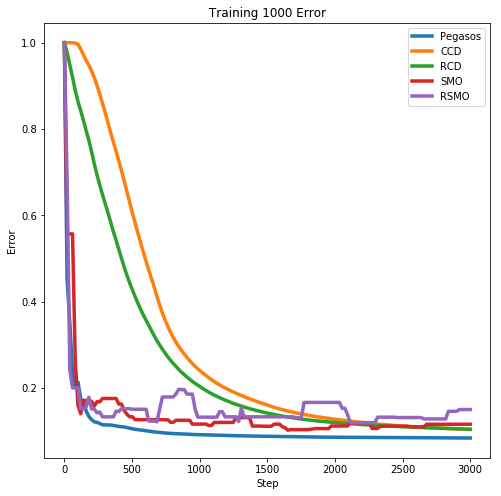

In [15]:
# training 1000 error plot
plot_dilation = 20
plt.figure(figsize=(8, 8))
plot_iters = 3000

error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, train_vectors_1000, train_labels_1000, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, train_vectors_1000, train_labels_1000, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, train_vectors_1000, train_labels_1000, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, train_vectors_1000, train_labels_1000, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, train_vectors_1000, train_labels_1000, 'rSMO', plot_dilation)

plt.title(' Training 1000 Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos acc: 0.988
CCD acc: 0.983
RCD acc: 0.983
SMO acc: 0.986
rSMO acc: 0.972


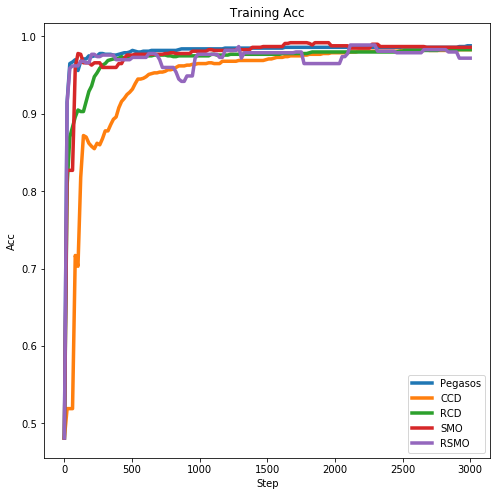

In [16]:
# training acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], train_vectors_1000, train_labels_1000, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], train_vectors_1000, train_labels_1000, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], train_vectors_1000, train_labels_1000, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], train_vectors_1000, train_labels_1000, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], train_vectors_1000, train_labels_1000, 'rSMO', plot_dilation)

plt.title(' Training Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos error: 0.10192198699893128
CCD error: 0.13124181154727396
RCD error: 0.12282870766196097
SMO error: 0.127707658885009
rSMO error: 0.15926769372750454


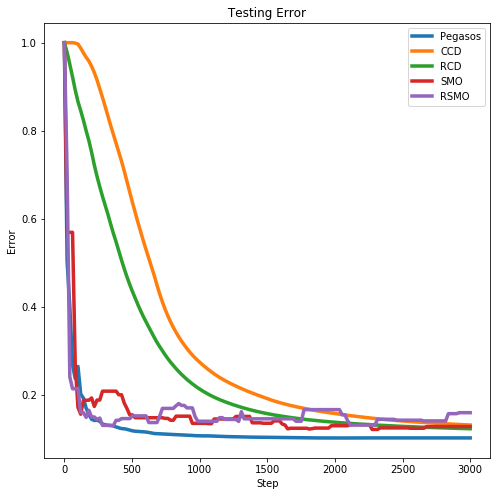

In [17]:
# test error plot
plt.figure(figsize=(8, 8))
error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, val_vectors, val_labels, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, val_vectors, val_labels, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, val_vectors, val_labels, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'rSMO', plot_dilation)
plt.title(' Testing Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos acc: 0.9808488612836439
CCD acc: 0.972567287784679
RCD acc: 0.9782608695652174
SMO acc: 0.9761904761904762
rSMO acc: 0.9632505175983437


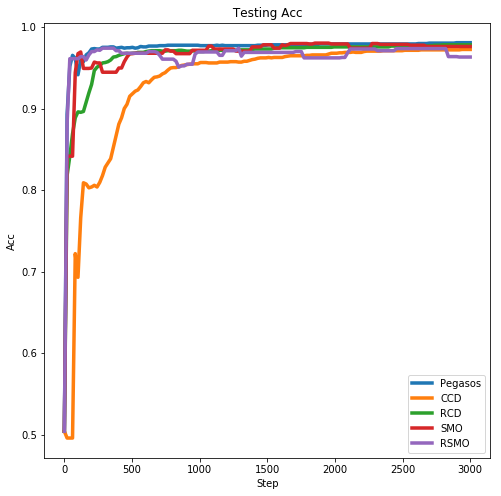

In [18]:
# test acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], val_vectors, val_labels, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], val_vectors, val_labels, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], val_vectors, val_labels, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], val_vectors, val_labels, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], val_vectors, val_labels, 'rSMO', plot_dilation)

plt.title(' Testing Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [19]:
# # 300
# # pegasos
# pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
# pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
#                         w0, [pegasos_lambda]*pegasos_num_steps, train_vectors_300, train_labels_300, proj)   # training
# pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
# print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors_300, train_labels_300)) # print final training error
# print("        ")

# # primal cyclic coordinate descent
# primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
# primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
#                         w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors_300, train_labels_300, t_bias, proj)
# primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
# print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors_300, train_labels_300))
# print("        ")

# # primal random coordinate descent
# primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
# primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
#                         w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors_300, train_labels_300, t_bias, proj)
# primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
# print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors_300, train_labels_300))
# print("        ")

# # SVM using SMO descend
# smo_model = SMO1(C=1.0)
# smo_model.fit(train_vectors_300, train_labels_300)
# print("        ")

# # Random SMO
# rsmo_model = RSMO1(C=1.0)
# rsmo_model.fit(train_vectors_300, train_labels_300)

In [20]:
# # training 3000 error plot
# plot_dilation = 20
# plt.figure(figsize=(8, 8))
# plot_iters = 3000

# error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, train_vectors_300, train_labels_300, 'Pegasos', plot_dilation)
# error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, train_vectors_300, train_labels_300, 'CCD', plot_dilation)
# error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, train_vectors_300, train_labels_300, 'RCD', plot_dilation)
# error_plot(smo_model.w_ls[:plot_iters], 1.0, train_vectors_300, train_labels_300, 'SMO', plot_dilation)
# error_plot(rsmo_model.w_ls[:plot_iters], 1.0, train_vectors_300, train_labels_300, 'rSMO', plot_dilation)

# plt.title(' Training 300 Error ')
# plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [21]:
# # training acc plot
# plt.figure(figsize=(8, 8))
# acc_plot(pegasos_output_weight[:plot_iters], train_vectors_10000, train_labels_10000, 'Pegasos', plot_dilation)
# acc_plot(primal_cyclic_cd_output_weight[:plot_iters], train_vectors_10000, train_labels_10000, 'CCD', plot_dilation)
# acc_plot(primal_random_cd_output_weight[:plot_iters], train_vectors_10000, train_labels_10000, 'RCD', plot_dilation)
# acc_plot(smo_model.w_ls[:plot_iters], train_vectors_10000, train_labels_10000, 'SMO', plot_dilation)
# acc_plot(rsmo_model.w_ls[:plot_iters], train_vectors_10000, train_labels_10000, 'rSMO', plot_dilation)

# plt.title(' Training Acc ')
# plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [22]:
# # test error plot
# plt.figure(figsize=(8, 8))
# error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, val_vectors, val_labels, 'Pegasos', plot_dilation)
# error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, val_vectors, val_labels, 'CCD', plot_dilation)
# error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, val_vectors, val_labels, 'RCD', plot_dilation)
# error_plot(smo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'SMO', plot_dilation)
# error_plot(rsmo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'rSMO', plot_dilation)
# plt.title(' Testing Error ')
# plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [23]:
# # test acc plot
# plt.figure(figsize=(8, 8))
# acc_plot(pegasos_output_weight[:plot_iters], val_vectors, val_labels, 'Pegasos', plot_dilation)
# acc_plot(primal_cyclic_cd_output_weight[:plot_iters], val_vectors, val_labels, 'CCD', plot_dilation)
# acc_plot(primal_random_cd_output_weight[:plot_iters], val_vectors, val_labels, 'RCD', plot_dilation)
# acc_plot(smo_model.w_ls[:plot_iters], val_vectors, val_labels, 'SMO', plot_dilation)
# acc_plot(rsmo_model.w_ls[:plot_iters], val_vectors, val_labels, 'rSMO', plot_dilation)

# plt.title(' Testing Acc ')
# plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])